In [74]:
import sys, os

path2add = os.path.normpath(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), os.path.pardir, "utils"))
)
if path2add not in sys.path:
    sys.path.append(path2add)

In [75]:
from utils.utils import perform_anova, perform_tukey_test, identify_outliers, analyze_market_size, bootstrap_mean, bootstrap_confidence_interval, calculate_effect_size

In [76]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
from statsmodels.stats.power import TTestIndPower

In [77]:
data_file = os.path.join(os.getcwd(), 'data', 'WA_Marketing-Campaign.csv')

try:
    df = pd.read_csv(data_file)
    print(df.head())
except FileNotFoundError:
    print(f"File not found: {data_file}")
    print("Please check the path and ensure the file exists.")

   MarketID MarketSize  LocationID  AgeOfStore  Promotion  week   
0         1     Medium           1           4          3     1  \
1         1     Medium           1           4          3     2   
2         1     Medium           1           4          3     3   
3         1     Medium           1           4          3     4   
4         1     Medium           2           5          2     1   

   SalesInThousands  
0             33.73  
1             35.67  
2             29.03  
3             39.25  
4             27.81  


In [78]:
df

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
...,...,...,...,...,...,...,...
543,10,Large,919,2,1,4,64.34
544,10,Large,920,14,2,1,50.20
545,10,Large,920,14,2,2,45.75
546,10,Large,920,14,2,3,44.29


In [79]:
print(df.isnull().sum())

MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64


Data contains no empty values

In [80]:
print(df.duplicated().sum())

0


Data contains no duplicates

In [81]:
df.groupby(["Promotion", "MarketSize"]).agg({"SalesInThousands": "mean"})

SalesInThousands
Promotion MarketSize                  
1         Large              75.235893
          Medium             47.672604
          Small              60.162500
2         Large              60.322031
          Medium             39.114352
          Small              50.810625
3         Large              77.203958
          Medium             45.468879
          Small              59.514167

So far from this we are able to see that\
Promotion 1 and 3 had the best performance on average.

In [82]:
df.groupby(["Promotion", "week"]).agg({"SalesInThousands": "mean"})

SalesInThousands
Promotion week                  
1         1            58.244419
          2            56.929535
          3            58.774884
          4            58.447209
2         1            47.730213
          2            47.582553
          3            47.722128
          4            46.282766
3         1            55.776170
          2            55.949149
          3            54.377872
          4            55.354681

Looking at the data from week perspective\
we are able to see that promotion 1 performed better.

In [83]:
df.groupby("Promotion").agg({"SalesInThousands": ["mean", "sum"]})

SalesInThousands          
                      mean       sum
Promotion                           
1                58.099012   9993.03
2                47.329415   8897.93
3                55.364468  10408.52

Despite higher mean in Promotion 1,\
Promotion 3 has larger sales sum.

In [84]:
df.groupby(["MarketID", "Promotion"]).agg({"SalesInThousands": "mean"})

SalesInThousands
MarketID Promotion                  
1        1                 40.719000
         2                 30.152000
         3                 33.989167
2        1                 65.600000
         3                 60.993500
3        1                 89.647143
         2                 79.592083
         3                 84.921667
4        1                 58.803125
         2                 50.810625
         3                 52.117500
5        1                 55.516250
         2                 45.917813
         3                 50.839000
6        1                 40.665000
         2                 32.596250
         3                 36.765000
7        1                 50.121250
         2                 39.361875
         3                 44.171071
8        1                 51.140000
         2                 42.497500
         3                 49.348000
9        1                 56.668333
         2                 49.982500
         3                 51.887500
10       1                 60.824643
         2                 48.760000
         3                 54.050833

### Anova test
The ANOVA test is used to determine whether there are any statistically\
significant differences between the means of three or more independent groups.

#### Hypothesis
H0: All promotions have the same effect on the outcome.\
Ha: At least one promotion has a different effect on the outcome.

In [85]:
market_ids = df['MarketID'].unique()
anova_results = {}
for market_id in market_ids:
    anova_results[market_id] = perform_anova(df, market_id)

anova_results_combined = pd.concat(anova_results, keys=market_ids)

anova_results_combined

sum_sq    df          F        PR(>F)
1  C(Promotion)  1135.924553   2.0  20.765733  2.939104e-07
   Residual      1340.195992  49.0        NaN           NaN
2  C(Promotion)    70.732808   1.0   4.517854  4.501133e-02
   Residual       344.438255  22.0        NaN           NaN
3  C(Promotion)  1306.730177   2.0  22.534452  1.405825e-08
   Residual      2464.494467  85.0        NaN           NaN
4  C(Promotion)   536.756851   2.0   9.991653  4.047490e-04
   Residual       886.388712  33.0        NaN           NaN
5  C(Promotion)   709.752046   2.0  19.771591  3.005160e-07
   Residual      1023.080714  57.0        NaN           NaN
6  C(Promotion)   713.180062   2.0   9.866168  2.091937e-04
   Residual      2060.134463  57.0        NaN           NaN
7  C(Promotion)   930.973407   2.0  16.887057  1.739867e-06
   Residual      1571.188087  57.0        NaN           NaN
8  C(Promotion)   432.167722   2.0   7.961767  1.095512e-03
   Residual      1221.308470  45.0        NaN           NaN
9  C(Promotion)   258.935186   2.0   3.522361  3.978280e-02
   Residual      1359.968892  37.0        NaN           NaN
10 C(Promotion)  2398.450887   2.0  57.353142  5.602649e-16
   Residual      1610.031388  77.0        NaN           NaN

Most MarketIDs show significant differences between promotions,\
as indicated by the low p-values and high F-statistics. This suggests\
that the promotions have a statistically significant effect on sales in these markets.

### Tukey's Honest Significant Difference
Tukey's Honest Significant Difference (HSD) test, which is a post-hoc\
test used after an ANOVA to find which specific group means are\
significantly different from each other.

Tukey HSD Test Results for MarketID 1
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  -10.567    0.0 -14.5641 -6.5699   True
     1      3  -6.7298 0.0026 -11.3453 -2.1143   True
     2      3   3.8372 0.1207  -0.7783  8.4527  False
-----------------------------------------------------


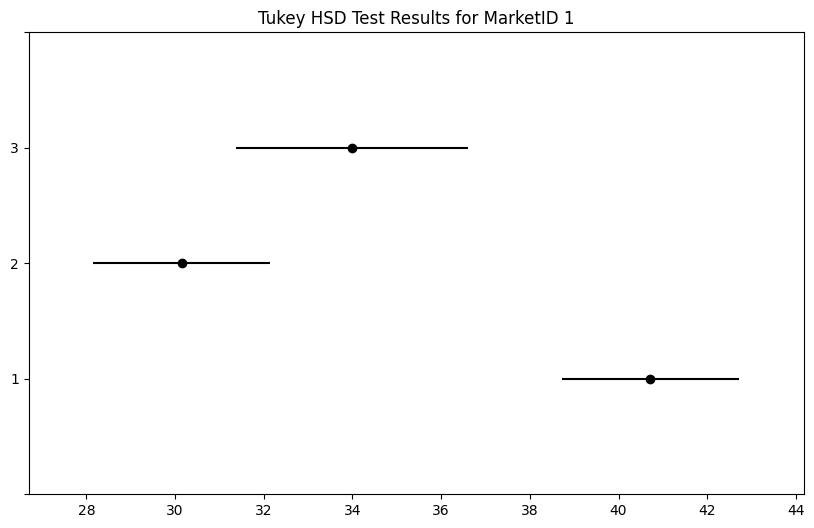

Tukey HSD Test Results for MarketID 2
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      3  -4.6065 0.045 -9.1011 -0.1119   True
---------------------------------------------------


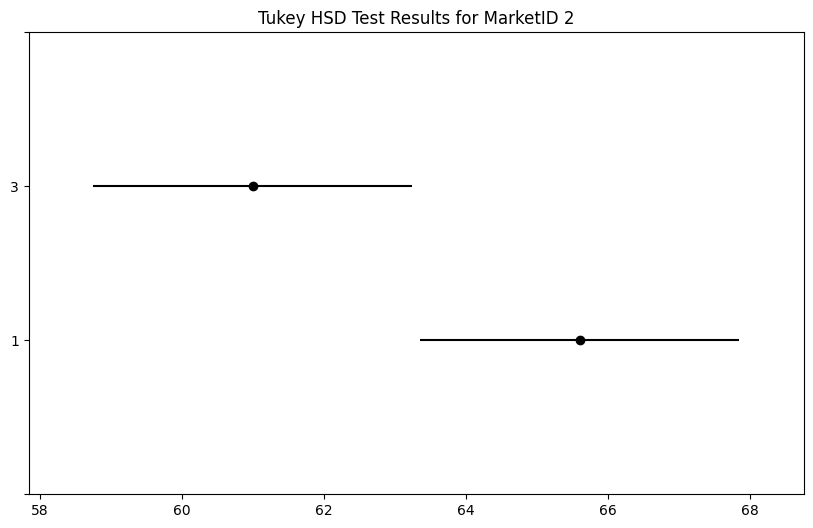

Tukey HSD Test Results for MarketID 3
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.0551    0.0 -13.6281  -6.482   True
     1      3  -4.7255 0.0022   -7.962 -1.4889   True
     2      3   5.3296 0.0009   1.9447  8.7145   True
-----------------------------------------------------


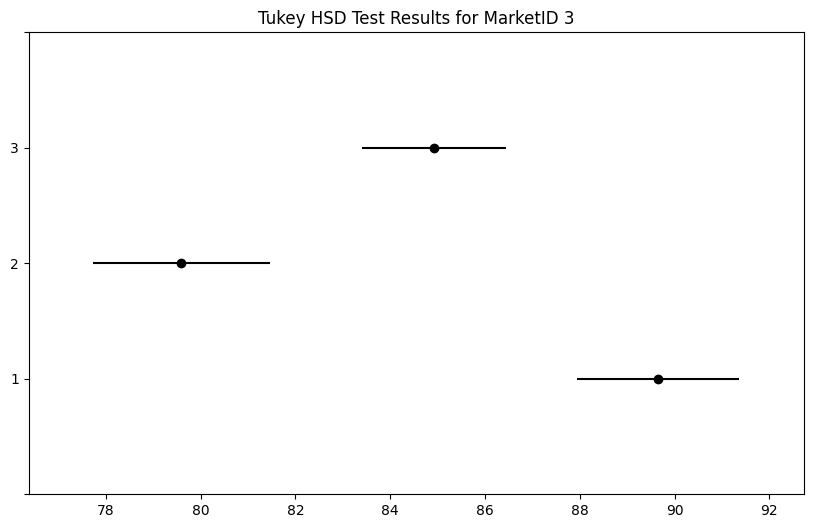

Tukey HSD Test Results for MarketID 4
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  -7.9925 0.0003 -12.4887 -3.4963   True
     1      3  -6.6856 0.0687 -13.7948  0.4235  False
     2      3   1.3069 0.8943  -5.8023   8.416  False
-----------------------------------------------------


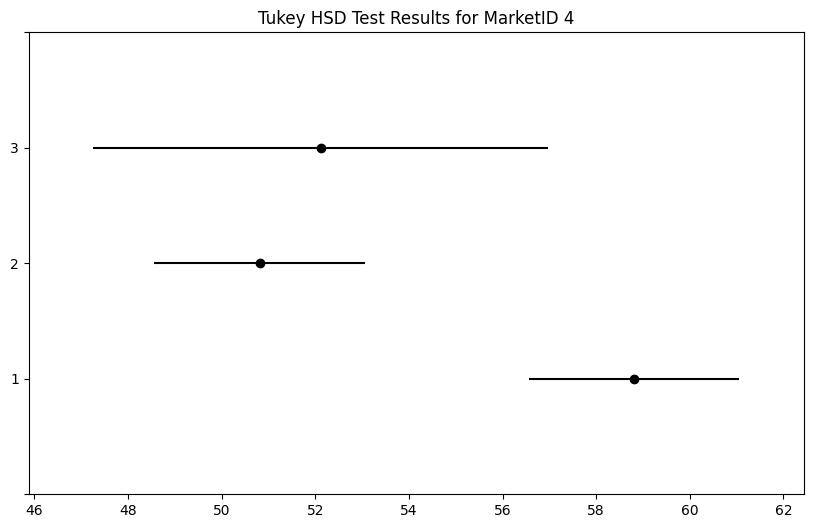

Tukey HSD Test Results for MarketID 5
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  -9.5984    0.0 -13.6284 -5.5685   True
     1      3  -4.6773 0.0284  -8.9421 -0.4124   True
     2      3   4.9212 0.0004   2.0152  7.8272   True
-----------------------------------------------------


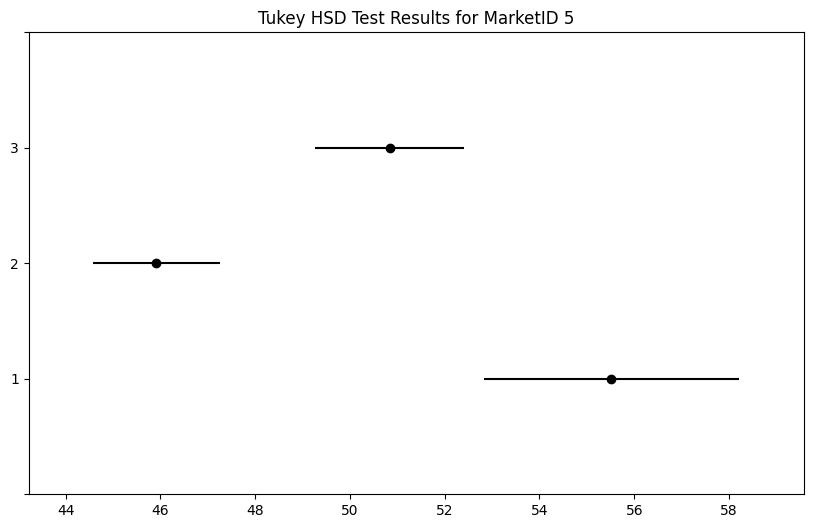

Tukey HSD Test Results for MarketID 6
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  -8.0688 0.0001 -12.4489 -3.6886   True
     1      3     -3.9 0.1385  -8.7524  0.9524  False
     2      3   4.1688 0.0892  -0.5005   8.838  False
-----------------------------------------------------


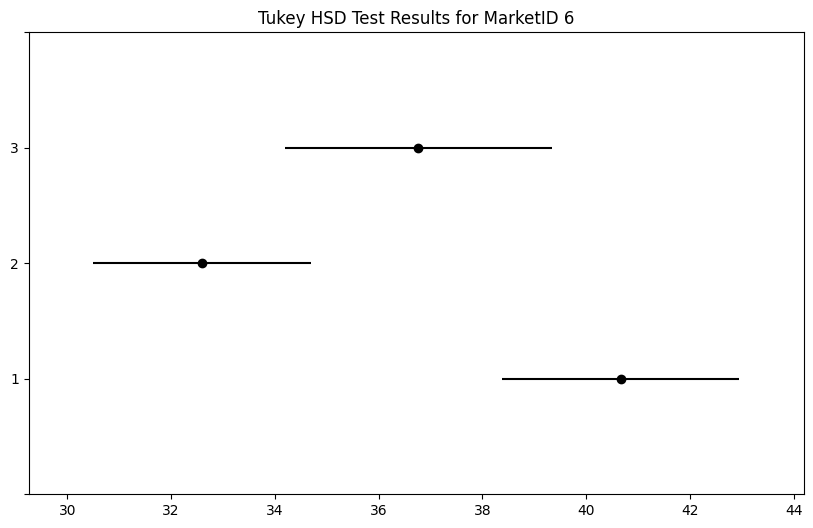

Tukey HSD Test Results for MarketID 7
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.7594    0.0 -15.2262 -6.2925   True
     1      3  -5.9502 0.0018  -9.9096 -1.9907   True
     2      3   4.8092 0.0136   0.8497  8.7686   True
-----------------------------------------------------


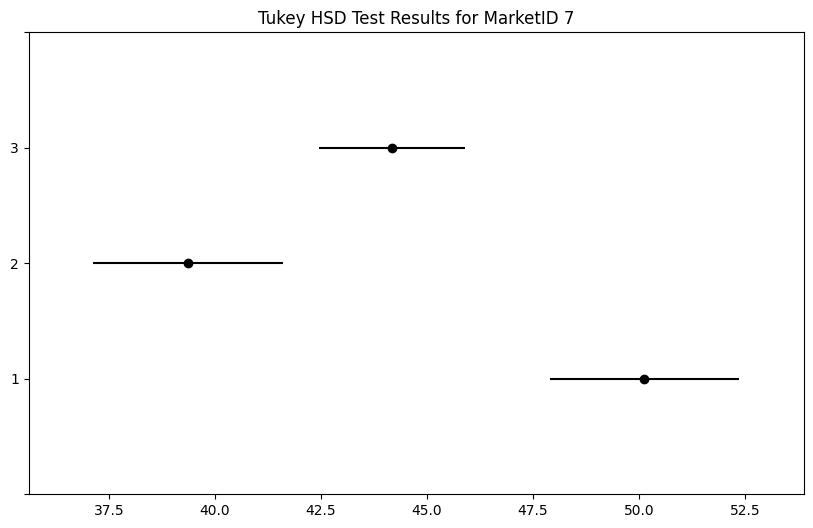

Tukey HSD Test Results for MarketID 8
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  -8.6425 0.0007 -13.9244 -3.3606   True
     1      3   -1.792 0.5265  -5.7847  2.2007  False
     2      3   6.8505 0.0082   1.5686 12.1324   True
-----------------------------------------------------


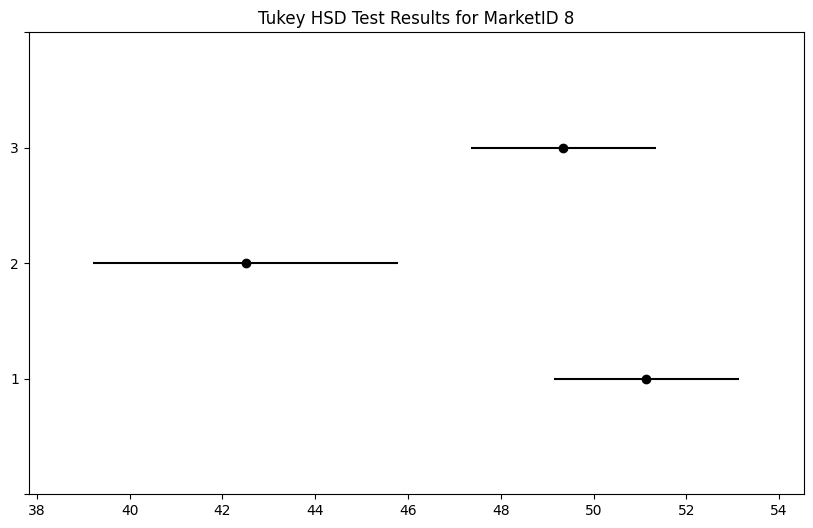

Tukey HSD Test Results for MarketID 9
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -6.6858 0.0529 -13.4419 0.0703  False
     1      3  -4.7808 0.0918 -10.1857 0.6241  False
     2      3    1.905 0.7348  -4.2871 8.0971  False
----------------------------------------------------


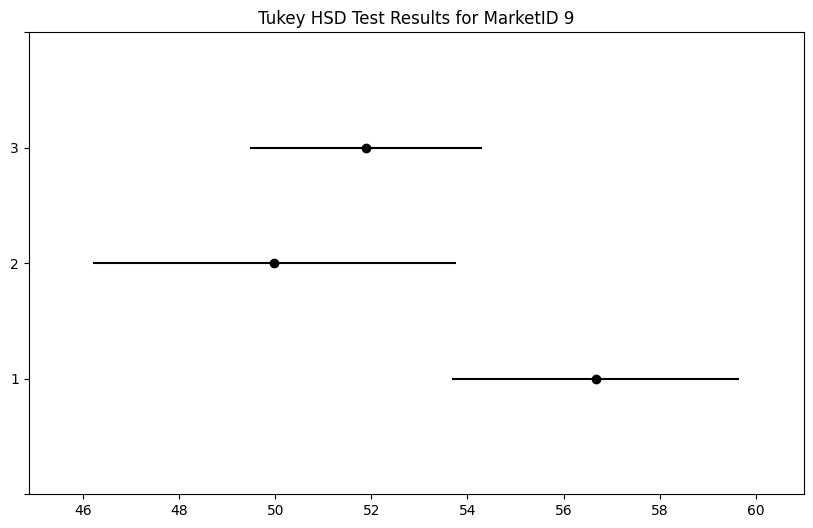

Tukey HSD Test Results for MarketID 10
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -12.0646    0.0 -14.7574 -9.3719   True
     1      3  -6.7738 0.0001 -10.5444 -3.0033   True
     2      3   5.2908 0.0021    1.694  8.8877   True
-----------------------------------------------------


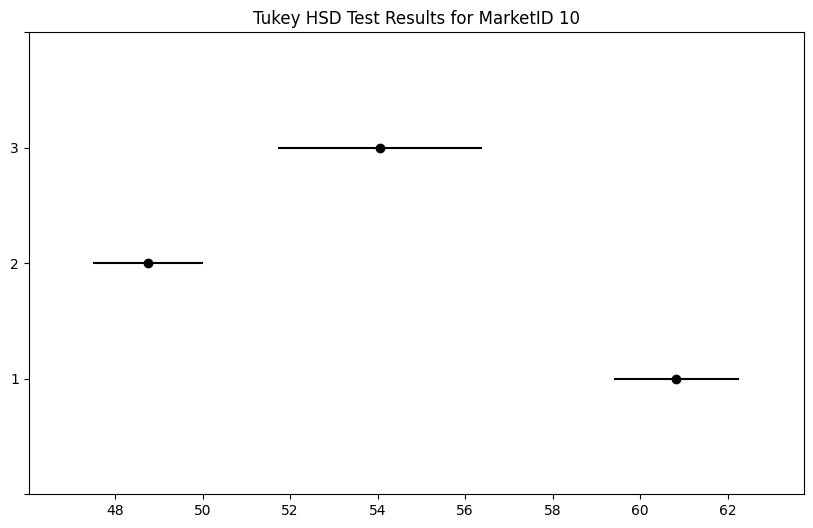

In [86]:
market_ids = df['MarketID'].unique()
for market_id in market_ids:
    perform_tukey_test(df, market_id)

Hypothesis Testing:
- Null Hypothesis (H0): There is no significant difference in the mean sales\
between any pair of promotions.
- Alternative Hypothesis (H1): There is a significant difference in the mean\
sales between at least one pair of promotions.

Summary of Results:
- Promotions 1 and 2 were frequently found to have significant differences in many markets.
- Promotion 3 often showed significant differences when compared with either Promotion 1 or 2,\
but there were cases where no significant differences were found.
- MarketID 9 did not show significant differences among any promotion pairs.

#### Promotions and Sales

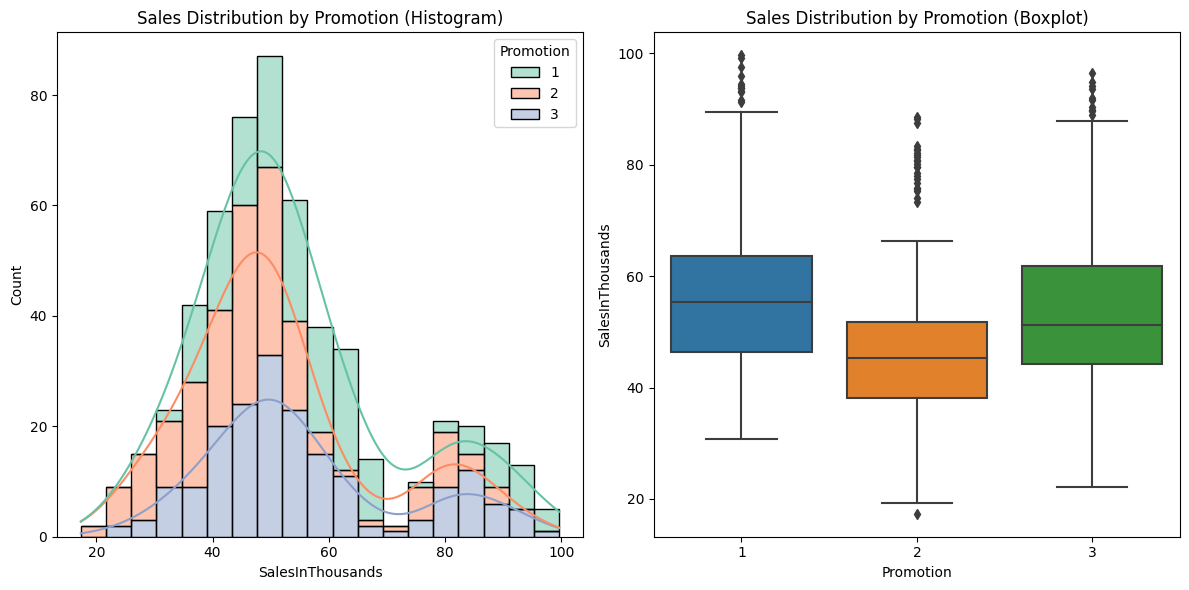

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

sns.histplot(data=df, x='SalesInThousands', hue='Promotion', multiple='stack', kde=True, palette='Set2', ax=axes[0])
axes[0].set_title('Sales Distribution by Promotion (Histogram)')

sns.boxplot(x='Promotion', y='SalesInThousands', data=df, ax=axes[1])
axes[1].set_title('Sales Distribution by Promotion (Boxplot)')

plt.tight_layout()
plt.show()

By looking overall sales distribution we are able to see that data is left skewed.\
Each promotion has a lot of outliers.

In [88]:
outliers = identify_outliers(df, 'SalesInThousands')

print("Outliers:")
outliers.groupby('Promotion').agg({"SalesInThousands": "mean"})

Outliers:


,SalesInThousands
Promotion,
1,92.847222
2,88.063333
3,91.423333


In [89]:
len(outliers)

33

In [90]:
grouped = df.groupby('Promotion')['SalesInThousands'].agg(['mean', 'std', 'count'])
print(grouped)

                mean        std  count
Promotion                             
1          58.099012  16.553782    172
2          47.329415  15.108955    188
3          55.364468  16.766231    188


#### Effect Size Calculation
Determine the required sample sizes for comparing different promotion levels

In [91]:
value_column = 'SalesInThousands'

sample_size_results = {}

promotion_levels = df['Promotion'].unique()

for (prom1, prom2) in combinations(promotion_levels, 2):
    promotion_group1 = df[df['Promotion'] == prom1][value_column]
    promotion_group2 = df[df['Promotion'] == prom2][value_column]
    

    if len(promotion_group1) > 1 and len(promotion_group2) > 1:
        effect_size = calculate_effect_size(promotion_group1, promotion_group2)
        
        analysis = TTestIndPower()
        sample_size = analysis.solve_power(effect_size=effect_size, alpha=0.05, power=0.8)
        
        sample_size_results[(prom1, prom2)] = round(sample_size)
    else:
        sample_size_results[(prom1, prom2)] = 'Not enough data'

print(sample_size_results)

promotion_counts = df['Promotion'].value_counts()

for (prom1, prom2), required_size in sample_size_results.items():
    if required_size == 'Not enough data':
        print(f"Comparison ({prom1} vs {prom2}): Not enough data to calculate required sample size.")
    else:
        count_prom1 = promotion_counts[prom1] if prom1 in promotion_counts else 0
        count_prom2 = promotion_counts[prom2] if prom2 in promotion_counts else 0
        sufficient_prom1 = count_prom1 >= required_size
        sufficient_prom2 = count_prom2 >= required_size
        print(f"Comparison ({prom1} vs {prom2}): Required sample size = {required_size}")
        print(f"Promotion {prom1}: {count_prom1} observations, {'sufficient' if sufficient_prom1 else 'insufficient'}")
        print(f"Promotion {prom2}: {count_prom2} observations, {'sufficient' if sufficient_prom2 else 'insufficient'}\n")

{(3, 2): 63, (3, 1): 584, (2, 1): 35}
Comparison (3 vs 2): Required sample size = 63
Promotion 3: 188 observations, sufficient
Promotion 2: 188 observations, sufficient

Comparison (3 vs 1): Required sample size = 584
Promotion 3: 188 observations, insufficient
Promotion 1: 172 observations, insufficient

Comparison (2 vs 1): Required sample size = 35
Promotion 2: 188 observations, sufficient
Promotion 1: 172 observations, sufficient



Comparison (3 vs 1): Both promotions have insufficient observations\
to meet the required sample size of 584. Since both Promotion 3 and\
Promotion 1 have fewer observations than the required sample size, the\
statistical power of the test will be lower than desired (0.8). This means\
there is a higher chance of Type II error (failing to detect a true effect)\
and the results might not be reliable.

#### Bootstraping

{(3, 2): (4.983892287234046, 11.16421808510636), (3, 1): (-6.264659852795644, 0.7504327065809028), (2, 1): (-14.21235669223157, -7.566331766452247)}


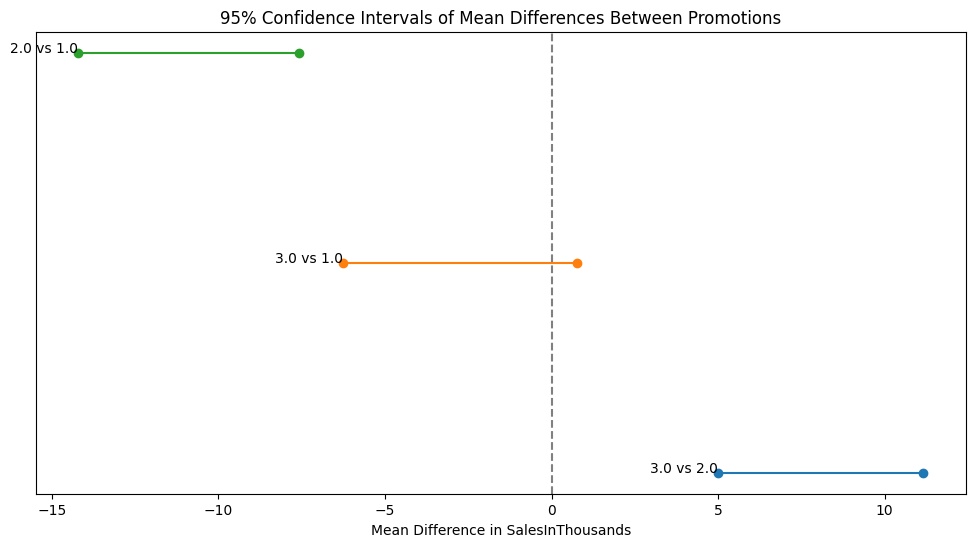

In [92]:
promotion_levels = df['Promotion'].unique()

ci_results = {}

for (prom1, prom2) in combinations(promotion_levels, 2):
    data1 = df[df['Promotion'] == prom1]['SalesInThousands']
    data2 = df[df['Promotion'] == prom2]['SalesInThousands']
    
    if len(data1) > 1 and len(data2) > 1:
        ci_lower, ci_upper = bootstrap_confidence_interval(data1, data2)
        ci_results[(prom1, prom2)] = (ci_lower, ci_upper)
    else:
        ci_results[(prom1, prom2)] = 'Not enough data'

print(ci_results)

ci_df = pd.DataFrame(ci_results, index=['Lower CI', 'Upper CI']).T.reset_index()
ci_df.columns = ['Promotion1', 'Promotion2', 'Lower CI', 'Upper CI']

plt.figure(figsize=(12, 6))
for i, row in ci_df.iterrows():
    plt.plot([row['Lower CI'], row['Upper CI']], [i, i], marker='o')
    plt.text(row['Lower CI'], i, f"{row['Promotion1']} vs {row['Promotion2']}", ha='right')
plt.axvline(0, color='grey', linestyle='--')
plt.title('95% Confidence Intervals of Mean Differences Between Promotions')
plt.xlabel('Mean Difference in SalesInThousands')
plt.yticks([])
plt.show()

Comparison (3 vs 2):
-  We are 95% confident that the true mean difference in sales\
between promotions 3 and 2 lies between 4.82 and 11.17. Since the\
entire interval is above zero, it suggests that promotion 3 has\
significantly higher average sales compared to promotion 2.

Comparison (3 vs 1):
- We are 95% confident that the true mean difference in sales\
between promotions 3 and 1 lies between -6.20 and 0.26. Since\
this interval crosses zero, it suggests that there may be no\
significant difference in average sales between promotion 3 and\
promotion 1. There is some evidence that promotion 3 could have\
lower average sales, but this is not conclusive.

Comparison (2 vs 1):
- We are 95% confident that the true mean difference in sales\
between promotions 2 and 1 lies between -13.93 and -7.47. Since\
the entire interval is below zero, it suggests that promotion 2\
has significantly lower average sales compared to promotion 1.

1 Promotion has the biggest sales mean from outliers perspective

In [93]:
model = ols('SalesInThousands ~ C(Promotion)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                     sum_sq     df          F        PR(>F)
C(Promotion)   11449.174291    2.0  21.953486  6.765849e-10
Residual      142114.105414  545.0        NaN           NaN


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.7696    0.0 -14.7738 -6.7654   True
     1      3  -2.7345 0.2444  -6.7388  1.2697  False
     2      3   8.0351    0.0   4.1208 11.9493   True
-----------------------------------------------------


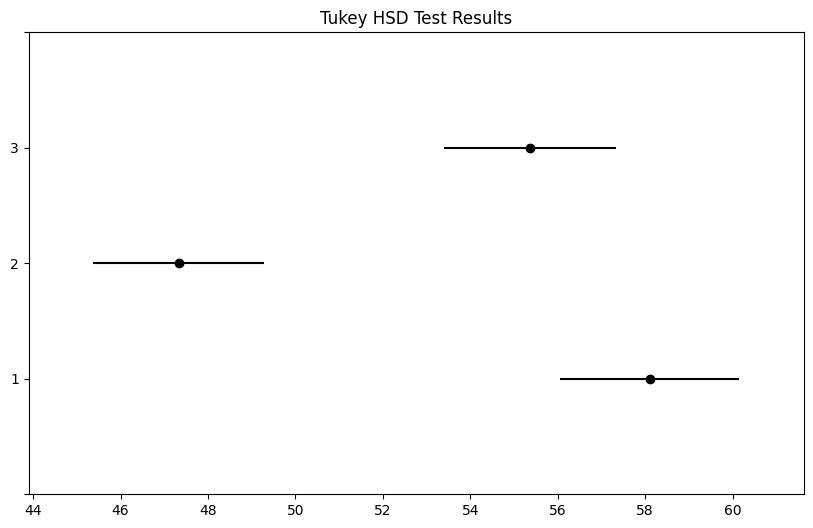

In [94]:
tukey = pairwise_tukeyhsd(endog=df['SalesInThousands'], groups=df['Promotion'], alpha=0.05)

print(tukey)

tukey.plot_simultaneous()
plt.title('Tukey HSD Test Results')
plt.show()

Hypothesis Testing
- Null Hypothesis (H0): There is no significant difference in the mean\
sales among the different promotions.
- Alternative Hypothesis (H1): There is a significant difference in the\
mean sales among the different promotions.

Based on the Tukey HSD test results, Promotion 1 should be chosen as it has\
significantly higher mean sales compared to both Promotion 3 and Promotion 2.\
The results indicate that Promotion 1 consistently outperforms the others in\
terms of sales, making it the most effective promotion among the three.

### Market sizes


Market Size: Small
Comparison (3 vs 2): 95% CI = (5.28, 12.29)
Comparison (3 vs 1): 95% CI = (-3.45, 2.13)
Comparison (2 vs 1): 95% CI = (-12.88, -5.97)

Market Size: Medium
Comparison (3 vs 2): 95% CI = (4.20, 8.46)
Comparison (3 vs 1): 95% CI = (-4.42, -0.04)
Comparison (2 vs 1): 95% CI = (-10.87, -6.48)

Market Size: Large
Comparison (3 vs 2): 95% CI = (11.26, 22.63)
Comparison (3 vs 1): 95% CI = (-3.56, 7.33)
Comparison (2 vs 1): 95% CI = (-20.43, -9.80)


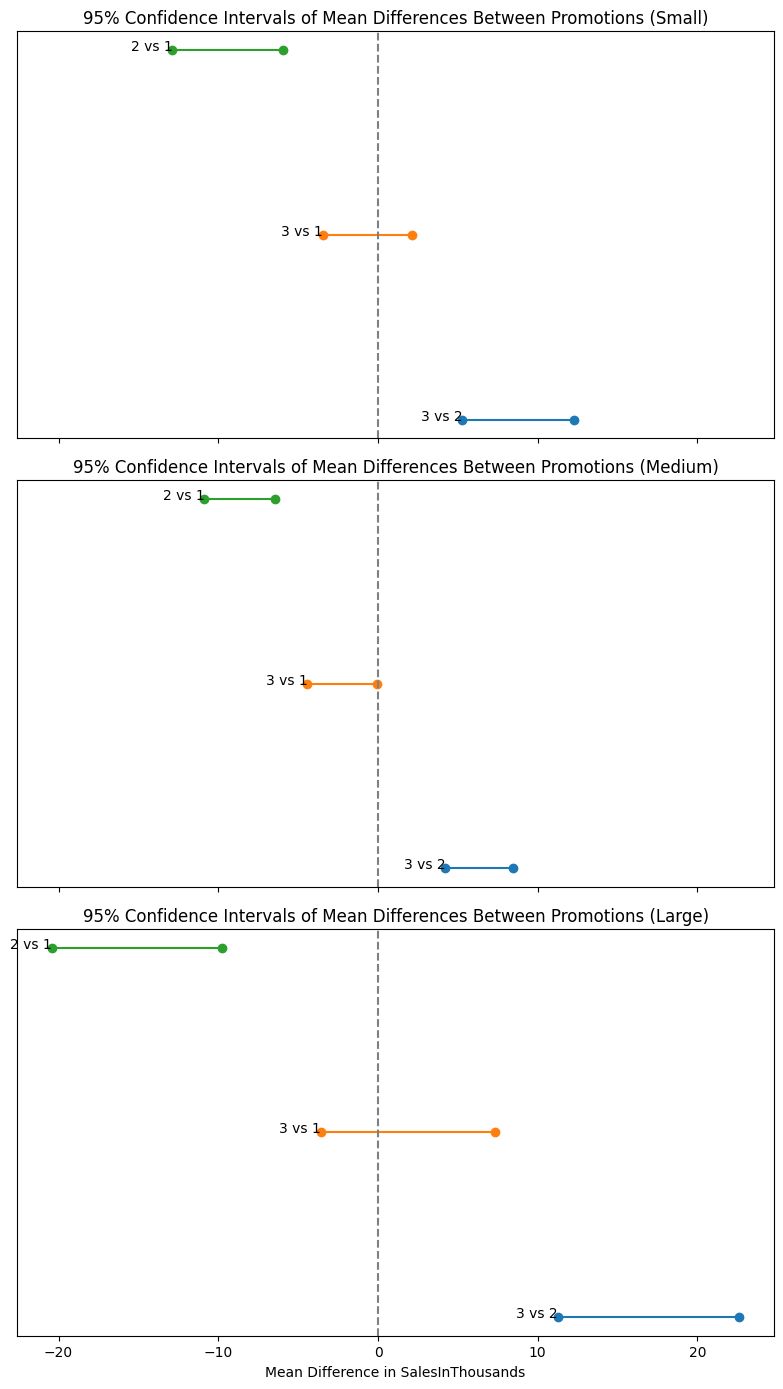

In [95]:
value_column = 'SalesInThousands'
market_sizes = ['Small', 'Medium', 'Large']

ci_results = {}

for market_size in market_sizes:
    df_market = df[df['MarketSize'] == market_size]
    ci_results[market_size] = {}
    for (prom1, prom2) in combinations(df['Promotion'].unique(), 2):
        data1 = df_market[df_market['Promotion'] == prom1][value_column]
        data2 = df_market[df_market['Promotion'] == prom2][value_column]
        
        if len(data1) > 1 and len(data2) > 1:
            ci_lower, ci_upper = bootstrap_confidence_interval(data1, data2)
            ci_results[market_size][(prom1, prom2)] = (ci_lower, ci_upper)
        else:
            ci_results[market_size][(prom1, prom2)] = 'Not enough data'

for market_size, results in ci_results.items():
    print(f"\nMarket Size: {market_size}")
    for (prom1, prom2), ci in results.items():
        if ci == 'Not enough data':
            print(f"Comparison ({prom1} vs {prom2}): Not enough data to calculate confidence interval.")
        else:
            ci_lower, ci_upper = ci
            print(f"Comparison ({prom1} vs {prom2}): 95% CI = ({ci_lower:.2f}, {ci_upper:.2f})")

ci_df_list = []
for market_size, results in ci_results.items():
    for (prom1, prom2), ci in results.items():
        if ci != 'Not enough data':
            ci_lower, ci_upper = ci
            ci_df_list.append([market_size, prom1, prom2, ci_lower, ci_upper])
ci_df = pd.DataFrame(ci_df_list, columns=['MarketSize', 'Promotion1', 'Promotion2', 'Lower CI', 'Upper CI'])

fig, axes = plt.subplots(nrows=len(market_sizes), ncols=1, figsize=(8, 14), sharex=True)

for ax, market_size in zip(axes, market_sizes):
    ci_df_market = ci_df[ci_df['MarketSize'] == market_size]
    for i, row in ci_df_market.iterrows():
        ax.plot([row['Lower CI'], row['Upper CI']], [i, i], marker='o')
        ax.text(row['Lower CI'], i, f"{row['Promotion1']} vs {row['Promotion2']}", ha='right')
    ax.axvline(0, color='grey', linestyle='--')
    ax.set_title(f'95% Confidence Intervals of Mean Differences Between Promotions ({market_size})')
    ax.set_yticks([])
    if market_size == market_sizes[-1]:
        ax.set_xlabel('Mean Difference in SalesInThousands')

plt.tight_layout()
plt.show()

- Promotion 3 vs Promotion 2: Promotion 3 consistently shows higher\
mean sales than Promotion 2 across all market sizes (Small, Medium, Large).
- Promotion 3 vs Promotion 1: There are no significant differences in\
sales between Promotion 3 and Promotion 1 in Small and Large markets.\
There is a marginal difference in Medium markets.
- Promotion 2 vs Promotion 1: Promotion 2 consistently shows lower mean\
sales than Promotion 1 across all market sizes (Small, Medium, Large).

ANOVA Results for Small Market Size
                   sum_sq    df          F    PR(>F)
C(Promotion)   954.613521   2.0  16.576481  0.000002
Residual      1641.270252  57.0        NaN       NaN
There is a statistically significant difference in mean sales among the promotions for Small market size.
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -9.3519    0.0 -13.683 -5.0208   True
     1      3  -0.6483 0.9161 -4.5579  3.2612  False
     2      3   8.7035    0.0  4.5359 12.8712   True
----------------------------------------------------


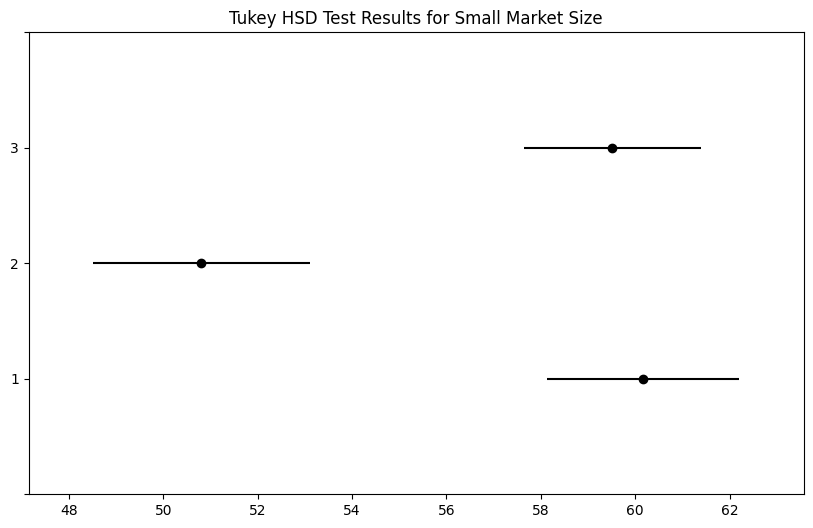

ANOVA Results for Medium Market Size
                    sum_sq     df          F        PR(>F)
C(Promotion)   4122.975904    2.0  29.688134  1.519740e-12
Residual      22011.881458  317.0        NaN           NaN
There is a statistically significant difference in mean sales among the promotions for Medium market size.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  -8.5583    0.0 -11.3107 -5.8058   True
     1      3  -2.2037 0.1356  -4.9111  0.5037  False
     2      3   6.3545    0.0   3.7307  8.9783   True
-----------------------------------------------------


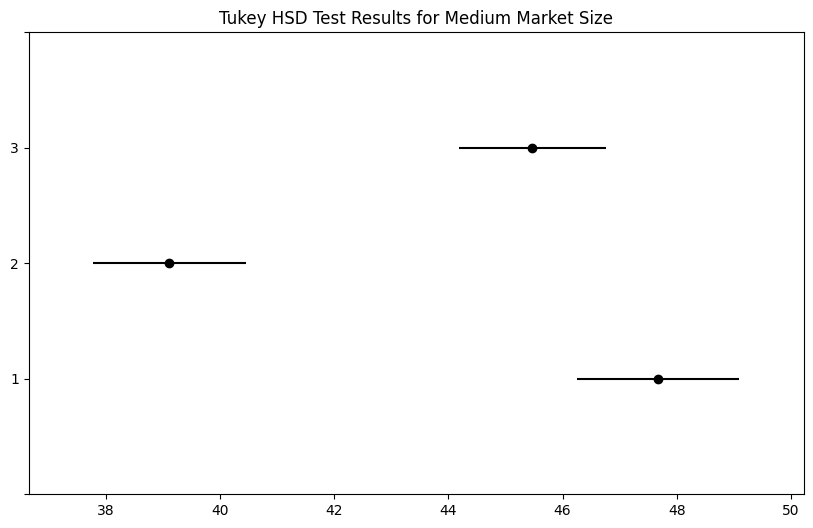

ANOVA Results for Large Market Size
                    sum_sq     df          F        PR(>F)
C(Promotion)  10018.420960    2.0  21.445111  5.261567e-09
Residual      38541.172539  165.0        NaN           NaN
There is a statistically significant difference in mean sales among the promotions for Large market size.
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     1      2 -14.9139   0.0 -21.5279 -8.2998   True
     1      3   1.9681  0.79  -5.1418   9.078  False
     2      3  16.8819   0.0   9.9802 23.7837   True
----------------------------------------------------


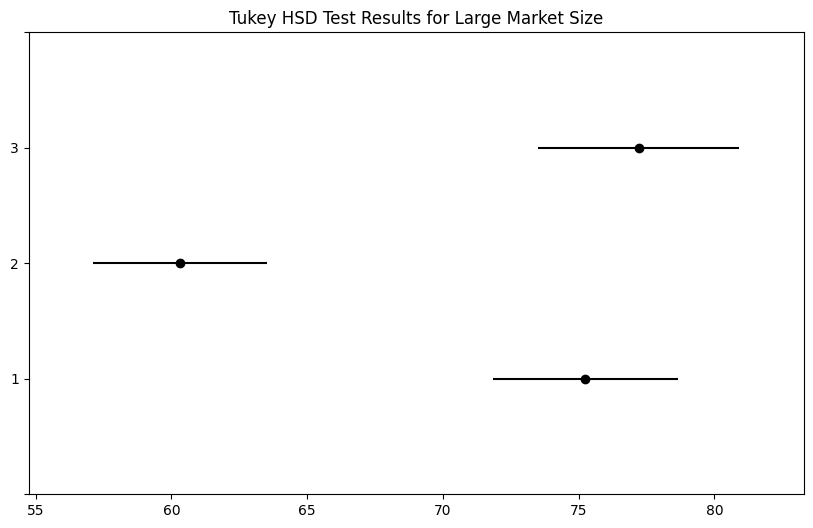

In [96]:
market_sizes = ['Small', 'Medium', 'Large']
for size in market_sizes:
    analyze_market_size(df, size)

Hypothesis Testing
- Null Hypothesis (H0): There is no significant difference in the mean\
sales among different promotions.
- Alternative Hypothesis (H1): There is a significant difference in the\
mean sales among different promotions.

Given that Promotion 3 shows consistently higher mean sales and is significantly\
better than Promotion 2 in all market sizes, while showing no significant difference\
with Promotion 1, Promotion 3 is still a strong candidate. However, considering your\
observation that Promotion 1 often has higher means.

#### Recommendations
Use Promotion 1 if your primary concern is the highest observed mean sales in most cases.